# **Klasifikasi Identitas Pembicara Menggunakan Fitur Linear Predictive Coding dan Metode Random Forest pada Dataset Japanese Vowels**

## **Business Understanding**

Dataset Japanese Vowels merekam pengucapan vokal bahasa Jepang dari beberapa pembicara berbeda, di mana setiap pengucapan direpresentasikan dalam bentuk data time series koefisien LPC (Linear Predictive Coding). Perbedaan pola LPC mencerminkan karakteristik fisiologis dan artikulasi masing-masing pembicaran

Tujuan:
- **klasifikasi identitas dari pembicara**
- evaluasi model yang digunakan

## **Data Understanding**

Data diambil melalui website -> https://timeseriesclassification.com/description.php?Dataset=JapaneseVowels

deskripsi singkat dataset:

UCI Archive dataset. 9 penutur pria Jepang direkam mengucapkan vokal 'a' dan 'e'. 'Analisis prediksi linier 12 derajat' diterapkan pada rekaman mentah untuk mendapatkan deret waktu dengan 12 dimensi, awalnya panjang antara 7 dan 29. Dalam kumpulan data ini, instans telah dilapisi ke panjang terpanjang, 29. Tugas klasifikasi adalah memprediksi pembicara. Oleh karena itu, setiap instans adalah ucapan yang diubah, nilai 12*29 dengan label kelas tunggal terpasang, [1...9]. Set pelatihan yang diberikan terdiri dari 30 ucapan untuk setiap pembicara, namun set pengujian memiliki distribusi yang bervariasi berdasarkan faktor eksternal waktu dan ketersediaan pengalaman, antara 24 dan 88 instans per pembicara. Referensi: M. Kudo, J. Toyama dan M. Shimbo. (1999).  "Multidimensional Curve Classification Using Passing-Through Regions". Pattern Recognition Letters, Vol. 20, No. 11--13, pages 1103--1111.


Ketika download terdapat 4 file:
JapaneseVowels_TRAIN.ts

1.   JapaneseVowels_TRAIN.ts
2.   JapaneseVowels_TEST.ts
1.  JapaneseVowels_eq_TRAIN.ts
4. JapaneseVowels_eq_TEST.ts


yang akan kita gunakan adalah 1 dan 2

perbedaan antar 1, 2 dan 3, 4 adalah di panjang time series yang sudah se seragamkan pada eq (equal-length)








### **Load Dataset**

ambil dataset dari file TRAIN dan TEST

In [ ]:
from sktime.datasets import load_from_tsfile_to_dataframe

X_train, y_train = load_from_tsfile_to_dataframe("JapaneseVowels_TRAIN.ts")
X_test, y_test   = load_from_tsfile_to_dataframe("JapaneseVowels_TEST.ts")


### **Struktur Dataset**

In [ ]:
print(X_train.shape)
print(type(y_train))

print(X_test.shape)
print(type(y_test))



(270, 12)
<class 'numpy.ndarray'>
(370, 12)
<class 'numpy.ndarray'>


In [ ]:
X_train.columns


Index(['dim_0', 'dim_1', 'dim_2', 'dim_3', 'dim_4', 'dim_5', 'dim_6', 'dim_7',
       'dim_8', 'dim_9', 'dim_10', 'dim_11'],
      dtype='object')

- data pada TRAIN terdiri dari 270 baris dengan 12 fitur LPC (dengan nama kolom dim_0 - dim_11)
- data pada TEST terdiri dari 370 baris dengan 12 fitur LPC




In [ ]:
X_train.iloc[0]['dim_0']


0     1.860936
1     1.891651
2     1.939205
3     1.717517
4     1.741191
5     1.684695
6     1.637373
7     1.643283
8     1.607030
9     1.617907
10    1.510350
11    1.371225
12    1.299045
13    1.221498
14    1.181849
15    1.161630
16    1.194990
17    1.264847
18    1.250698
19    1.261441
dtype: float64

Visualisasi

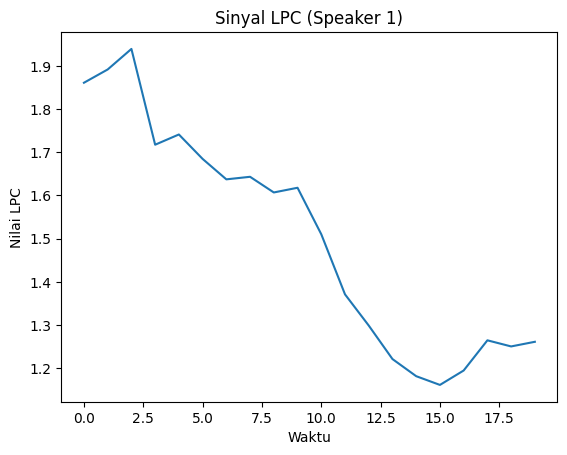

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X_train.iloc[0, 0].values)
plt.title(f"Sinyal LPC (Speaker {y_train[0]})")
plt.xlabel("Waktu")
plt.ylabel("Nilai LPC")
plt.show()


Setiap frame merepresentasikan potongan sinyal suara berdurasi sekitar 20–30 ms. jumlah frame yang terekam pada setiap sampel mencerminkan durasi pengucapan vokal, di mana sampel dengan jumlah frame lebih sedikit menunjukkan durasi suara yang lebih singkat.

### **Distribusi Kelas**

In [ ]:
import pandas as pd

y_series = pd.Series(y_train)
print(y_series.value_counts())


1    30
2    30
3    30
4    30
5    30
6    30
7    30
8    30
9    30
Name: count, dtype: int64


Kelas terdiri dari 9 orang penutur orang dari jepang dan setiap class mempunyai 30 baris data dan terlihat data seimbang

### **Cek Missing Value**

In [ ]:
# Missing pada label
print("Missing label:", y_series.isnull().sum())

# Missing pada data
missing_count = 0
for i in range(len(X_train)):
    for d in range(X_train.shape[1]):
        if X_train.iloc[i, d].isnull().any():
            missing_count += 1

print("Series mengandung missing:", missing_count)


Missing label: 0
Series mengandung missing: 0


Data pada train tidak memiliki missing value

### **Cek Duplikasi Data**

In [ ]:
rows_repr = X_train.applymap(lambda s: tuple(s.values)).astype(str)
print("Jumlah data duplikat:", rows_repr.duplicated().sum())


Jumlah data duplikat: 0


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_23112\1759289553.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  rows_repr = X_train.applymap(lambda s: tuple(s.values)).astype(str)


Data train tidak memiliki duplikasi data

### **Panjang Time-Series**

In [ ]:
lengths = [len(X_train.iloc[i, 0]) for i in range(len(X_train))]

print("Min length:", min(lengths))
print("Max length:", max(lengths))


Min length: 7
Max length: 26


Perbandingan dua speaker


ambil perbanding lpc 1 pada sampe pertama dan 51

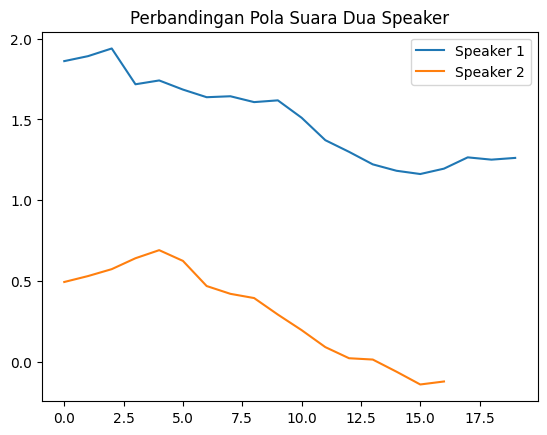

In [ ]:
plt.plot(X_train.iloc[0,0].values, label=f"Speaker {y_train[0]}")
plt.plot(X_train.iloc[50,0].values, label=f"Speaker {y_train[50]}")
plt.legend()
plt.title("Perbandingan Pola Suara Dua Speaker")
plt.show()


Grafik perbandingan pola suara menunjukkan perbedaan yang jelas pada nilai antara dua speaker yang berbeda. Perbedaan pola ini menunjukkan bahwa fitur LPC efektif dalam merepresentasikan ciri khas pembicara dan dapat dimanfaatkan dalam proses klasifikasi identitas speaker.

### **Histogram 12 LPC**

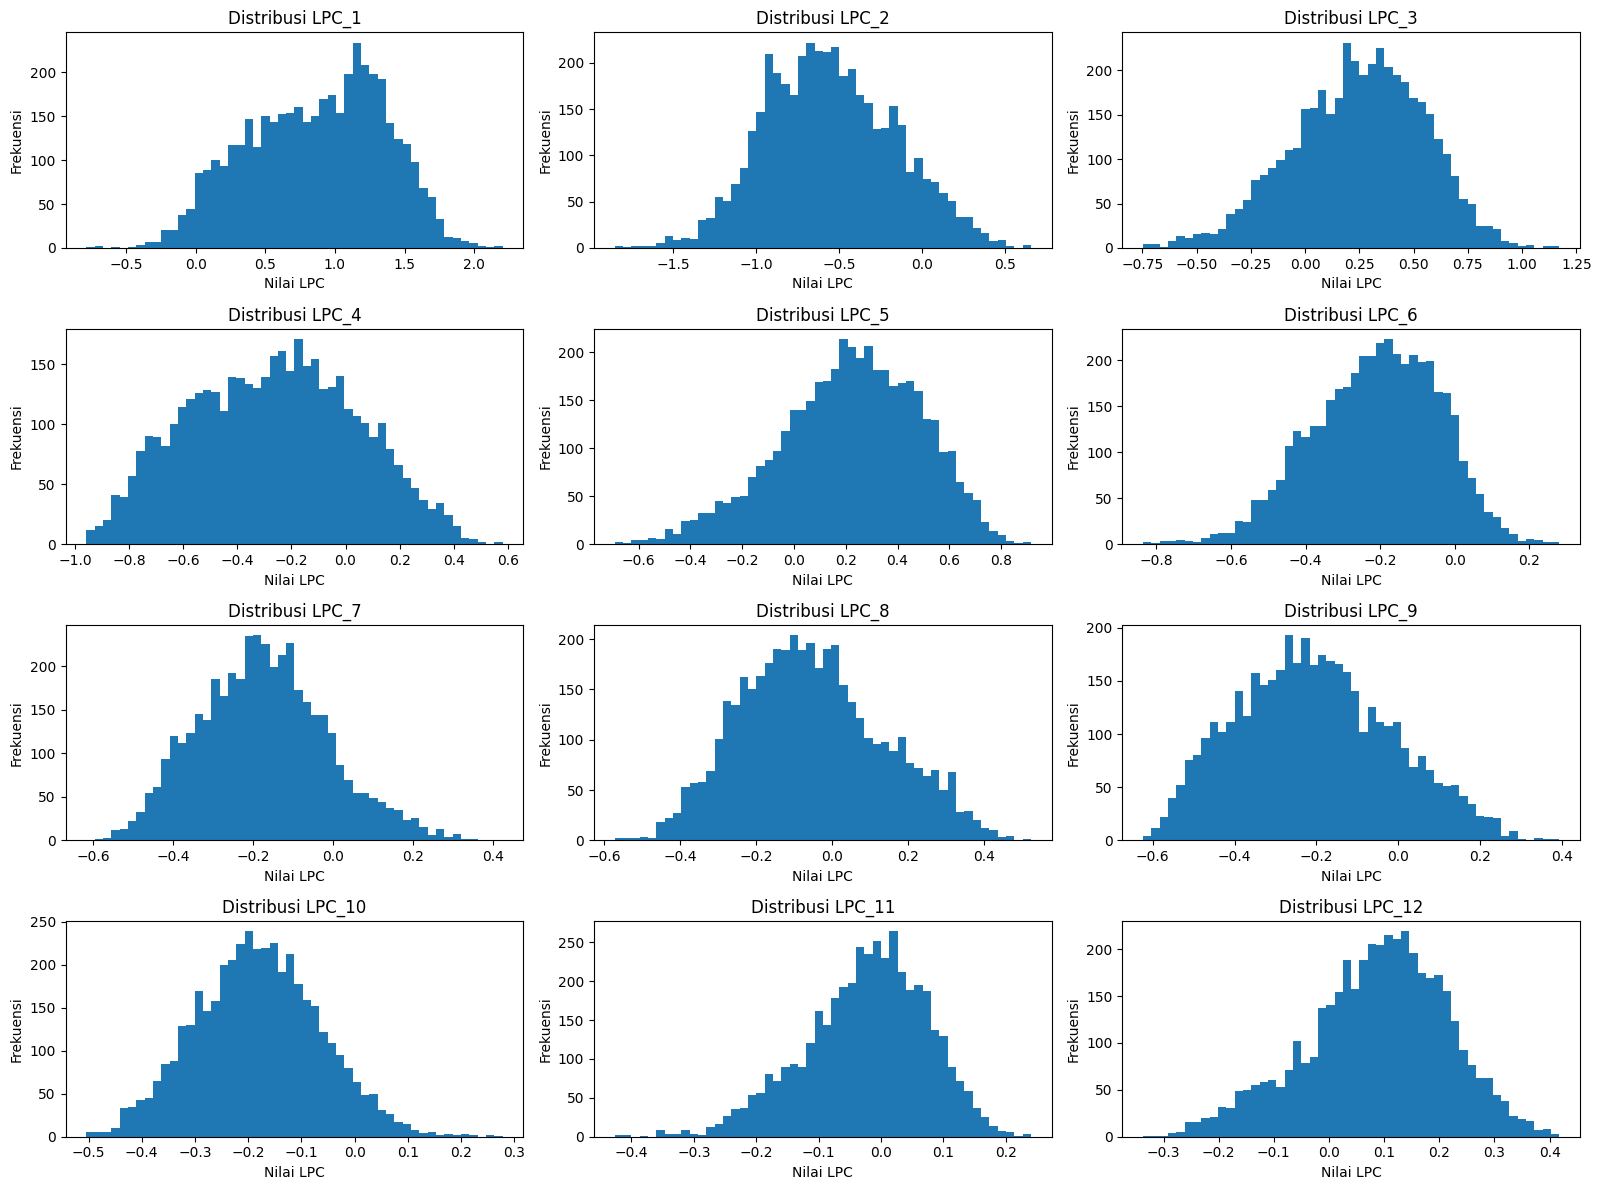

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))

for i in range(12):
    values = np.concatenate([X_train.iloc[j, i].values for j in range(len(X_train))])

    plt.subplot(4, 3, i+1)
    plt.hist(values, bins=50)
    plt.title(f"Distribusi LPC_{i+1}")
    plt.xlabel("Nilai LPC")
    plt.ylabel("Frekuensi")

plt.tight_layout()
plt.show()


Histogram distribusi nilai untuk seluruh fitur LPC menunjukkan pola sebaran yang relatif stabil pada masing-masing dimensi. Setiap fitur LPC memiliki rentang nilai dan frekuensi tertentu yang mencerminkan karakteristik spektral sinyal suara. Secara umum, distribusi nilai LPC tidak didominasi oleh nilai ekstrem

### Distribusi Panjang Time-Series

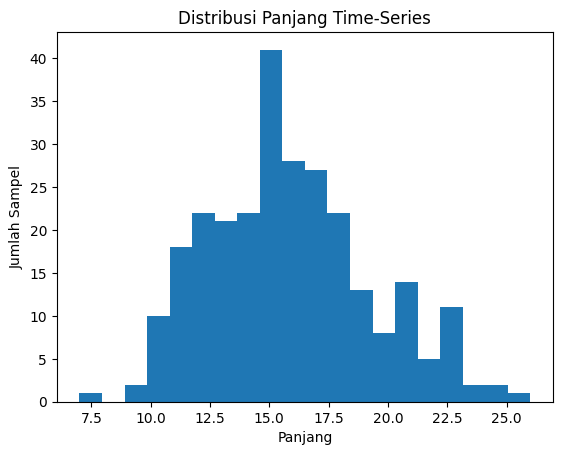

In [ ]:
plt.hist(lengths, bins=20)
plt.title("Distribusi Panjang Time-Series")
plt.xlabel("Panjang")
plt.ylabel("Jumlah Sampel")
plt.show()


Histogram distribusi panjang time-series menunjukkan bahwa jumlah frame pada setiap sampel suara bervariasi dengan rentang tertentu. Sebagian besar sampel memiliki panjang time-series pada kisaran nilai tengah, sementara sejumlah kecil sampel memiliki durasi yang lebih pendek atau lebih panjang. Variasi panjang ini mencerminkan perbedaan durasi pengucapan vokal antar pembicara

## **Prepocessing**

Dari hasil data understanding sebelumnya, kita tidak perlu melakukan prepocessing data seperti:
1. penanganan missing value (karena tidak ada missing value)
2. penanganan data duplikat (karena tidak ada data duplikat)
3. penanganan anomali (karena tidak terdapat nilai ekstrem)
4. balancing data (karena distribusi class sudah merata)
5. split data (karena dari sumber dataet sudah terpisah untuk train dan test)

kita akan melakukan preocessing:
- padding untuk menyeragamkan panjang data time series
- ekstraksi fitur

### Padding Global untuk Menyeragamkan Panjang Time-Series


Kode ini bertujuan untuk menyeragamkan panjang data time-series yang semula bervariasi antar sampel suara. Dataset Japanese Vowels memiliki panjang deret waktu yang berbeda-beda karena variasi durasi pengucapan vokal

In [ ]:
import numpy as np

def nested_to_numpy_padded_global(Xtrain, Xtest):
    maxlen = 0
    for X in [Xtrain, Xtest]:
        for i in range(len(X)):
            for d in range(X.shape[1]):
                maxlen = max(maxlen, len(X.iloc[i,d]))

    def pad(X):
        arr = np.zeros((len(X), X.shape[1], maxlen))
        for i in range(len(X)):
            for d in range(X.shape[1]):
                seq = X.iloc[i,d].values
                arr[i,d,:len(seq)] = seq
        return arr

    return pad(Xtrain), pad(Xtest), maxlen

Xtr, Xte, MAXLEN = nested_to_numpy_padded_global(X_train, X_test)


### Ekstraksi Fitur Statistik dari Data Time-Series

karena 1 sampel memiliki 12 LPC, dan setiap LPC memiliki jumlah frame yang SAMA di dalam satu sampel,
tetapi jumlah frame bisa BERBEDA antar sampel. maka perlu ekstraksi

Kode ini digunakan untuk mengubah data time-series menjadi data tabular melalui proses ekstraksi fitur statistik. Karena algoritma klasifikasi seperti Random Forest tidak dapat langsung memproses data time-series dengan panjang variabel, setiap deret waktu perlu direpresentasikan dalam bentuk fitur numerik yang ringkas.

Untuk setiap fitur LPC, dihitung:

- Rata-rata (mean) → nilai pusat deret waktu
- Simpangan baku (std) → tingkat variasi
- Nilai minimum (min) → nilai terendah
- Nilai maksimum (max) → nilai tertinggi

Dengan 12 fitur LPC, dihasilkan:
- 12 × 4 = 48 fitur per sampel suara

In [ ]:
import numpy as np

def extract_stat_features(X):
    feats = []
    for i in range(len(X)):
        row_feat = []
        for d in range(X.shape[1]):
            ts = X.iloc[i, d].values
            row_feat.extend([
                np.mean(ts),
                np.std(ts),
                np.min(ts),
                np.max(ts)
            ])
        feats.append(row_feat)
    return np.array(feats)

Xtr_feat = extract_stat_features(X_train)
Xte_feat = extract_stat_features(X_test)

print("Xtr_feat shape:", Xtr_feat.shape)  # (270, 48)
print("Xte_feat shape:", Xte_feat.shape)  # (370, 48)


Xtr_feat shape: (270, 48)
Xte_feat shape: (370, 48)


Tampilan setelah di ekstraksi

In [ ]:
import pandas as pd

columns = []
for i in range(12):
    columns.extend([
        f"LPC_{i+1}_mean",
        f"LPC_{i+1}_std",
        f"LPC_{i+1}_min",
        f"LPC_{i+1}_max"
    ])

df_tabular = pd.DataFrame(Xtr_feat, columns=columns)
df_tabular.head()


,LPC_1_mean,LPC_1_std,LPC_1_min,LPC_1_max,LPC_2_mean,LPC_2_std,LPC_2_min,LPC_2_max,LPC_3_mean,LPC_3_std,...,LPC_10_min,LPC_10_max,LPC_11_mean,LPC_11_std,LPC_11_min,LPC_11_max,LPC_12_mean,LPC_12_std,LPC_12_min,LPC_12_max
0,1.502918,0.254803,1.161630,1.939205,-0.418295,0.137924,-0.638350,-0.193249,0.136697,0.098737,...,-0.364329,-0.204974,-0.123078,0.075004,-0.247722,-0.019119,0.041759,0.101328,-0.175986,0.141055
1,1.538459,0.155661,1.288280,1.981364,-0.468067,0.206939,-0.665777,0.067256,0.447557,0.165089,...,-0.256385,-0.029453,-0.121045,0.088312,-0.245750,0.093058,0.094078,0.049437,0.011129,0.248909
2,1.634643,0.236610,1.260190,2.125260,-0.531556,0.368967,-1.042286,0.174066,0.451911,0.113728,...,-0.478964,-0.208580,0.011720,0.084574,-0.146977,0.175298,0.158911,0.069948,-0.015915,0.248583
3,1.470260,0.169118,1.160837,1.704241,-0.701176,0.362288,-1.090194,0.078806,0.583251,0.204799,...,-0.406532,0.038970,-0.029967,0.117695,-0.204131,0.133377,0.063417,0.104000,-0.098507,0.178910
4,1.546129,0.130048,1.251355,1.756285,-0.586279,0.244485,-0.960896,-0.238987,0.312081,0.143216,...,-0.289957,-0.047579,-0.086722,0.091001,-0.293401,0.063014,0.121366,0.091296,0.008935,0.329654


## **Modeling**

In [ ]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# flatten fitur LPC
Xtr_feat = extract_stat_features(X_train)

# pipeline
model = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    ))
])

# training
model.fit(Xtr_feat, y_train)

# simpan model
joblib.dump(model, "jv_rf_pipeline.pkl")
print("✅ Model JapaneseVowels berhasil disimpan")


✅ Model JapaneseVowels berhasil disimpan


Kode ini membangun pipeline machine learning yang terdiri dari dua tahap utama:

1. StandardScaler
    Digunakan untuk melakukan normalisasi fitur sehingga setiap fitur memiliki rata-rata nol dan simpangan baku satu. Meskipun Random Forest relatif tidak sensitif terhadap skala, proses ini tetap dilakukan untuk menjaga konsistensi pipeline dan memungkinkan penggunaan model lain di masa depan.

2.  RandomForestClassifier
Model ini digunakan untuk melakukan klasifikasi identitas pembicara berdasarkan fitur LPC. Random Forest dipilih karena:

- Mengurangi risiko overfitting melalui ensemble decision tree

Parameter penting:

- n_estimators=500 → jumlah pohon keputusan

- random_state=42 → memastikan reprodusibilitas

- n_jobs=-1 → memanfaatkan seluruh core CPU

## **Evaluasi**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test,
    y_pred,
    digits=4
))


              precision    recall  f1-score   support

           1     0.9355    0.9355    0.9355        31
           2     0.9688    0.8857    0.9254        35
           3     0.9560    0.9886    0.9721        88
           4     1.0000    1.0000    1.0000        44
           5     0.9355    1.0000    0.9667        29
           6     1.0000    1.0000    1.0000        24
           7     1.0000    0.9750    0.9873        40
           8     0.9200    0.9200    0.9200        50
           9     0.8929    0.8621    0.8772        29

    accuracy                         0.9568       370
   macro avg     0.9565    0.9519    0.9538       370
weighted avg     0.9569    0.9568    0.9565       370



Hasil evaluasi menunjukkan bahwa model Random Forest yang dibangun mampu mengklasifikasikan identitas pembicara dengan sangat baik. Nilai accuracy sebesar 95,68% didukung oleh nilai precision, recall, dan F1-score yang tinggi pada hampir seluruh kelas. Beberapa kelas bahkan menunjukkan performa sempurna dengan nilai precision dan recall sebesar 1.00. Hal ini mengindikasikan bahwa fitur LPC yang digunakan mampu merepresentasikan karakteristik suara pembicara secara efektif dan model yang dibangun memiliki kemampuan generalisasi yang baik.

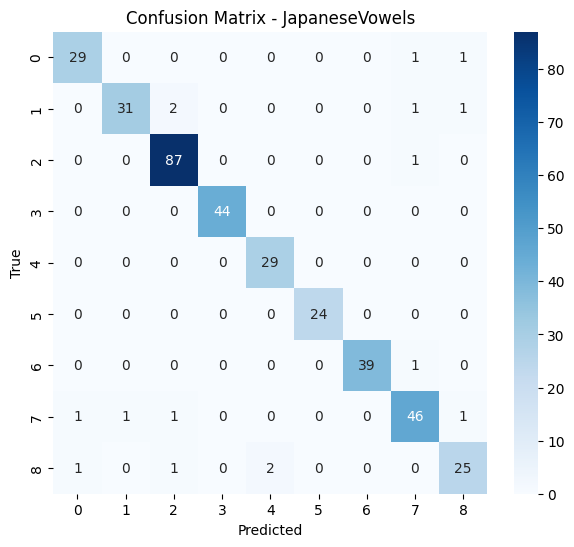

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - JapaneseVowels")
plt.show()


## Deployment

Setelah melakukan modeling, didapatkan hasil machine learning -> jv_rf_pipeline.pkl

Deployment dilakukan di streamlit dengan cara:

- buat repository baru di github (saya menamakan dengan uas_japanesevowels)
- buat file app.py
- upload file jv_rf_pipeline.pkl
- buat file requirements.txt

anda dapat melihatn detail di -> https://github.com/yudhacm/uas_japanesevowels

masuk ke streamlit dengan login github dan pilih repository anda:

Hasil deploy dapat dilihat di link:
https://230411100057-uas-psd.streamlit.app/

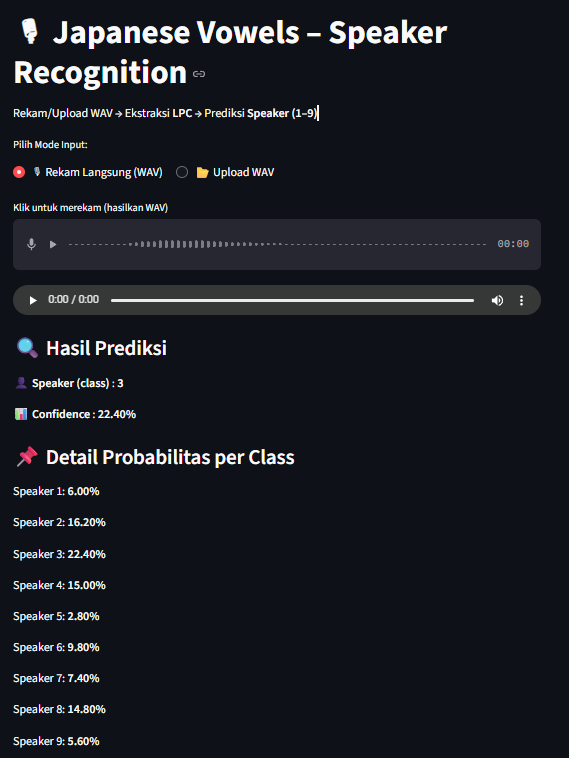!